## Motion History Images (MHI)

In [ ]:
import numpy as np
import scipy
from scipy import signal
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from skimage import draw as drw
from skimage import color, img_as_float, morphology
import skimage
import cv2
import pims

### 1. What are MHIs?

One of the most well-known methods for action representation and recognition is the Motion History Image method. The MHI is a temporal template that contains the history of motion of a video sequence. The core idea is that moving parts of a video sequence can be engraved in a single image, from where one can predict the motion flow as well as the moving parts of the action. Some important features of the MHI representation are:

• It can represent a motion sequence in a compact manner. A silhouette sequence is detected and condensed into a gray scale image, where the dominant motion information is preserved.

• It can be implemented in low illumination conditions where structure cannot be easily detected otherwise, e.g. surveillance applications.

• It is not very sensitive to silhouette noise, holes, shadows, and missing parts. However, if there is a significant presence of shadow in the moving scene, it will be incorporated in the image.

• It keeps a history of temporal changes at each pixel location, addressing both intensity and direction. The motion flow is expressed by using the intensity of every pixel. Older motions are depicted in darker shades of gray, while more recent (or current) motions are depicted in lighter shades. It follows that motion direction is represented by darker to lighter pixel intensity transitions. 

See the images below for a clearer and more straightforward example.

<img src="img1.PNG">

### 2. Dataset in use

We will visualise a couple of frames from the video dataset which we're going to use in this activity. A man is jogging and we're going to detect and represent his motions. Analogous datasets can be found at the reference link.

Reference: https://www.csc.kth.se/cvap/actions/

In [ ]:
# import video
v = pims.Video('jogging.avi')
T = len(v) # number of extracted frames
print(T)

304


Text(0.5, 1.0, 'Frame 31')

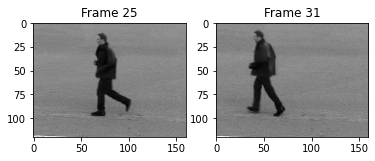

In [ ]:
# sample frames (grayscale)

a, b = 25, 31
Ig1=img_as_float(color.rgb2gray(v[a]))
Ig2=img_as_float(color.rgb2gray(v[b]))

# visualise

plt.subplot(121)
plt.imshow(Ig1,cmap='gray')
plt.title('Frame {}'.format(a))
plt.subplot(122)
plt.imshow(Ig2,cmap='gray')
plt.title('Frame {}'.format(b))

### 3. Object segmentation

Our goal is to obtain a final representation which highlights the man's body $and$ his movements, so we first set up a frame by frame object segmentation technique and keep the motion detection aside for a while. In the final steps, we will combine this with the MHIs, i.e. combine object presence and motion in a single representation.

Here, we want to use an object detection technique which helps us distinguish the jogging man from the background. For each frame, our goal is to obtain a binary image whose pixel values are 1 if the person is detected and 0 otherwise.

For our simple example, some thresholding on the gray levels of the frames should be enough to separate the object of interest from the background, but more refined techniques can be employed. We start by looking at histograms of gray-level intensities.

$\mathbf{Note}$: as an alternative, one can use a Canny edge detector to detect the person's silhouette and fill the space within the edges with white pixels, frame by frame. Canny detectors may leave some small gaps between edges belonging to the same object, so one should also use some connectivity techniques to fill them and hope to obtain some closed figures.

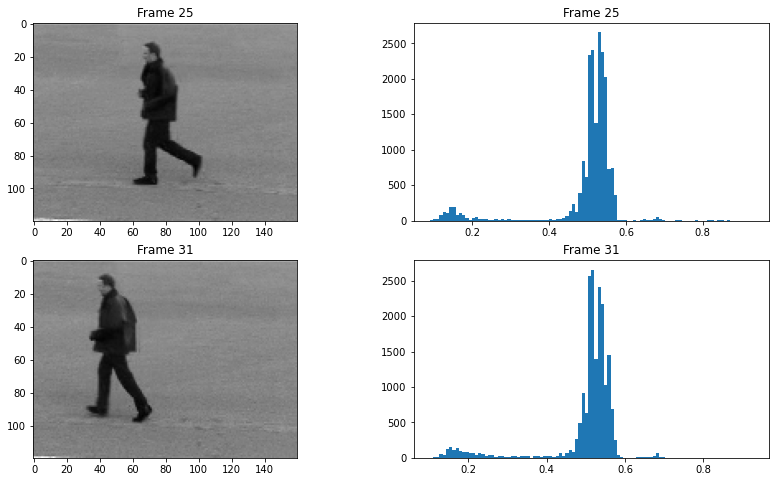

In [ ]:
# simple thresholding

plt.figure(figsize=(14,8))
plt.subplot(221)
plt.imshow(Ig1,cmap='gray')
plt.title('Frame {}'.format(a))
plt.subplot(222)
plt.hist(Ig1.ravel(),100)
plt.title('Frame {}'.format(a))
plt.subplot(223)
plt.imshow(Ig2,cmap='gray')
plt.title('Frame {}'.format(b));
plt.subplot(224)
plt.hist(Ig2.ravel(),100)
plt.title('Frame {}'.format(b))
plt.show()

We are looking at the histograms of gray levels for the pair of sample frames seen before. The majority of pixels are 'medium' gray and they probably belong to the background. We can guess that pixels belonging to the jogging man are instead located in the black section of the histogram (left side of the x-axis) and appear to be well separated from the background.

In the cell below, we'll use both an automatic method and Otsu's method to compute an optimal threshold for binary separation. Where do you expect the optimal threshold to be?

In [ ]:
# threshold choice

# automatic choice

def condition(x,thresh): return x > thresh # helping function

max_iter = 10 # stop if convergence was not achieved after a given number of steps
sigma = 0.5 # std of the gaussian filter for image pre-smoothing
tolerance = 10e-4 # tolerance for threshold value convergence
idx = np.random.randint(0,T-1,size=50) # sample a set of frame indices
threshs = []

for ix in idx:
    thresh_auto = 0.45 # initial threshold choice
    iteration = 0
    ig = img_as_float(color.rgb2gray(v[ix])).ravel()
    ig = scipy.ndimage.gaussian_filter1d(ig, sigma) # smooth the image for better separation and outlier removal
    while iteration < max_iter:
        left = [i for i,el in enumerate(ig) # separate pixels based on threshold
                if condition(el,thresh_auto)]
        right = [i for i,el in enumerate(ig)
                if not condition(el,thresh_auto)]
        t = 0.5*(np.mean(ig[left]) + np.mean(ig[right])) # recompute threshold
        if (np.abs(thresh_auto - t) > tolerance) & (math.isnan(t) == False):
            thresh_auto = t
        elif (np.abs(thresh_auto - t) <= tolerance) & (math.isnan(t) == False):
            iteration = max_iter
        iteration += 1
    threshs.append(thresh_auto)

thresh_auto = np.mean(threshs)
    
print('Automatic threshold is {:.3f}'.format(thresh_auto))
        
# otsu's method
# for comparison, we are using the same subset of frames as before

from skimage.filters import threshold_otsu
threshs_otsu = []

for ix in idx:
    ig = img_as_float(color.rgb2gray(v[ix]))
    ig = scipy.ndimage.gaussian_filter1d(ig, sigma) # again, first smooth the image
    thresh_otsu = threshold_otsu(ig)
    threshs_otsu.append(thresh_otsu)
    
thresh_otsu = np.mean(threshs_otsu)

print('Otsu threshold is {:.3f}'.format(thresh_otsu))

Automatic threshold is 0.425
Otsu threshold is 0.430


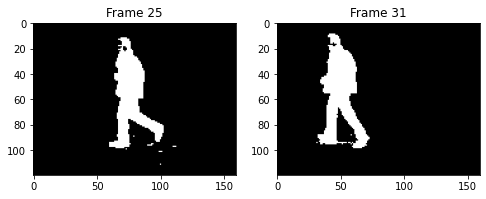

In [ ]:
# we now apply thresholding with respect to otsu's optimal threshold

v_fill = []
for i in range(T):
    ig = img_as_float(color.rgb2gray(v[i]))
    ig = scipy.ndimage.gaussian_filter1d(ig, sigma)
    ig = (ig < thresh_otsu).astype(int)
    v_fill.append(ig)

plt.figure(figsize=(8,6))
plt.subplot(121)
plt.imshow(v_fill[a], cmap='gray')
plt.title('Frame {}'.format(a))
plt.subplot(122)
plt.imshow(v_fill[b], cmap='gray')
plt.title('Frame {}'.format(b))
plt.show()

We will use these masks in the next cells. Now, we move towards MHIs and address the motion detection issue across frames with respect to motion intensity and direction.

### 4. Motion Energy Images (MEI)

We first look at Motion Energy Images (MEI) which highlight the regions of an image where motion has occurred in the last few frames. The MEI is a binary image, where white pixels represent the motion-occurring pixels and the black pixels denote static pixels. There is no explicit information here as to when or how motion has occurred.

Let $I(x, y, t)$ be a frame at time $t$, and let $D(x, y, t)$ be a binary difference image sequence indicating regions of motion at time $t$ with respect to time $t-1$.

$$D(x, y, t) = I(x, y, t) − I(x, y, t - 1)$$

We also define the $\Psi(x, y, t)$ function. $\Psi$ detects object presence and/or motion in the current frame $I(x, y, t)$ and can be seen as the binarisation of $D$ with respect to a threshold $\xi$, combined with the object segmentation technique seen in section 3:


$$
\begin{equation}
    \Psi (x, y, t) =  
        \begin{cases}
            1 & \text{if |D(x, y, t)| > $ξ$ $\lor$ object is present}\\
            0 & \text{otherwise}
         \end{cases}
\end{equation}
$$

Finally, the MEI $E(x, y, t)$ is defined as:
$$ E(x, y, t) = \bigcup\limits_{i=0}^{\tau - 1} \Psi(x, y, t-i)$$
where the duration $\tau$ defines the temporal extent of the action. The MEI is a cumulative binary image, as it keeps track of all the pixels which have undergone any changes in the last $\tau-1$ frames, going backwards in time from the current frame $t$.

In [ ]:
# compute the frame difference images D

tau = 10
D_list = list()
D_list.append(np.zeros_like(v_fill[0]))
for t in range(1,T):
    D = (img_as_float(color.rgb2gray(v[t])) - img_as_float(color.rgb2gray(v[t-1])))
    D_list.append(D)

In [ ]:
# compute the Psi images
# Remember that we want to include BOTH presence and motion in the binarisation of Psi

csi = 0.09
Psi_list = list()
Psi_list.append(v_fill[0])
for t in range(1,T):    
    Psi_tmp = (np.abs(D_list[t]) > csi).astype(int) + v_fill[t]
    Psi = (Psi_tmp != 0).astype(int)
    Psi_list.append(Psi)

In [ ]:
# compute the Motion Energy Images E

E_list = list()
for t in range(tau-1,T):
    tmp = np.zeros_like(Psi_list[0])
    for ix in range(t-tau+1,t+1):
        tmp += Psi_list[ix]
    E = (tmp != 0).astype(int)
    E_list.append(E)

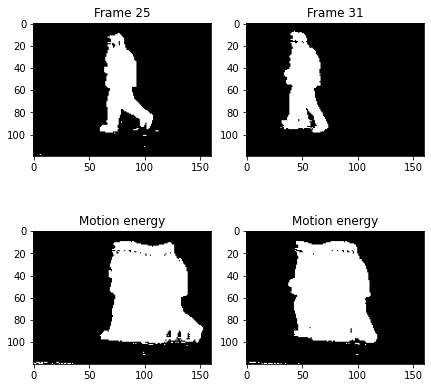

In [ ]:
# plot some sample Psi and E images

plt.figure(figsize=(7,7))
plt.subplot(221)
plt.imshow(Psi_list[a],cmap='gray')
plt.title('Frame {}'.format(a))
plt.subplot(222)
plt.imshow(Psi_list[b],cmap='gray')
plt.title('Frame {}'.format(b))
plt.subplot(223)
plt.imshow(E_list[a-tau],cmap='gray')
plt.title('Motion energy')
plt.subplot(224)
plt.imshow(E_list[b-tau],cmap='gray')
plt.title('Motion energy')
plt.show()

The $\Psi$ and $E$ images are just preliminary to our task and do not necessarily provide a complete description of motion in the current frame, as they just describe $\textit{where}$ the object presence (or motion) is (or has been).

We move now to the computation of the motion history images $H$, which should provide a clearer output and also give a deeper insight as to $\textit{how}$ motion occurs, as opposed to $\textit{where}$.

### 5. Motion History Images (MHI)

In order to represent how the object in the image is moving, we form a motion history image (MHI). In an MHI $H$, pixel intensity is a function of the temporal history of motion at that instant. It is constructed by successively layering selected image regions over time, using a simple update rule:


$$
\begin{equation}
    H (x, y, t) =  
        \begin{cases}
            \tau & \text{if $\Psi$(x, y, t) = 1}\\
            \max\{0, H(x,y,t-1) - \delta\} & \text{otherwise}
         \end{cases}
\end{equation}
$$

where $\tau$ is the same parameter which we have defined before and $\delta$ is the decaying parameter, i.e. by how much we reduce the pixel intensity with respect to the previous frame if no further motion was detected.
For the current frame, we expect pixels where the object is to be represented in white, recent motions to be represented in lighter shades of gray, while the trace of less recent ones to be progressively darker gray. The background, or any regions where no object is or was detected, are going to be black.

References: https://web.cse.ohio-state.edu/~davis.1719/Publications/event01.pdf

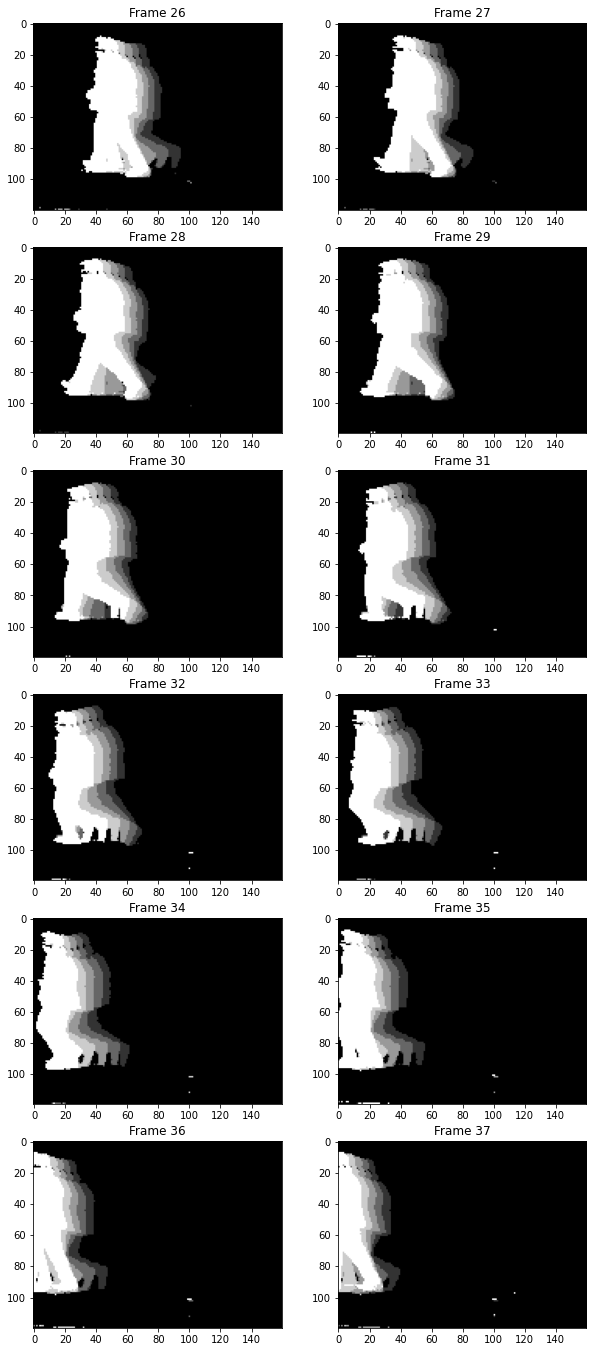

In [ ]:
# compute the motion history images H

delta = 2
H_list = list()
H_list.append(v_fill[0])
for t in range(1,T-1):
    H = (Psi_list[t]*tau) + (1-Psi_list[t])*np.maximum(0,H_list[t-1]-delta)
    H_list.append(H)

# show a sample sequence    
    
plt.figure(figsize=(10,24))
for i in range(12):
    plt.subplot(6,2,i+1)
    plt.imshow(H_list[i+b],cmap='gray')
    plt.title('Frame {}'.format(i+1+a))

We have formed our MHIs. As we can see, they can keep track of motion in a way that intrinsically contains information about both intensity and direction. Note that the preliminary object segmentation procedure was not perfect, e.g. the man's head was hardly detected, as its skin colour is too similar to the background, but it's enough to let us see where the man is.

Note that the MEI can be retrieved from the MHI with a simple binarisation, i.e. MEI values are 1 if the MHI is equal or larger than 1, 0 otherwise.

The MHI comes with some limitations. Just to mention some, if more than one person is moving in the scene, the MHI cannot distinguish between them (solution: include tracking with bounding boxes and IDs). Also, there can be a so-called 'motion overwriting', e.g. if a person is running from left to right, then turns back and runs from right to left, some information will be missed as motions will overlap in the final MHI (if tau and delta are large enough). The same happens with periodic motions. All motions will be detected by the MHI, therefore, if the purpose of the analysis were to isolate just one specific motion, e.g. hand-waving of a walking person, the MHI alone is not enough as it would also detect and represent the walking action.

### 6. Testing

Now, the $\tau$, $\xi$ and $\delta$ parameters can be adjusted in order to see how the final output is affected. Try and see if you can get any better results or just look at the effect of changing the parameter values.

Optionally, download another video dataset from the reference link posted above and see if and how this procedure can be repeated with a different image sequence.

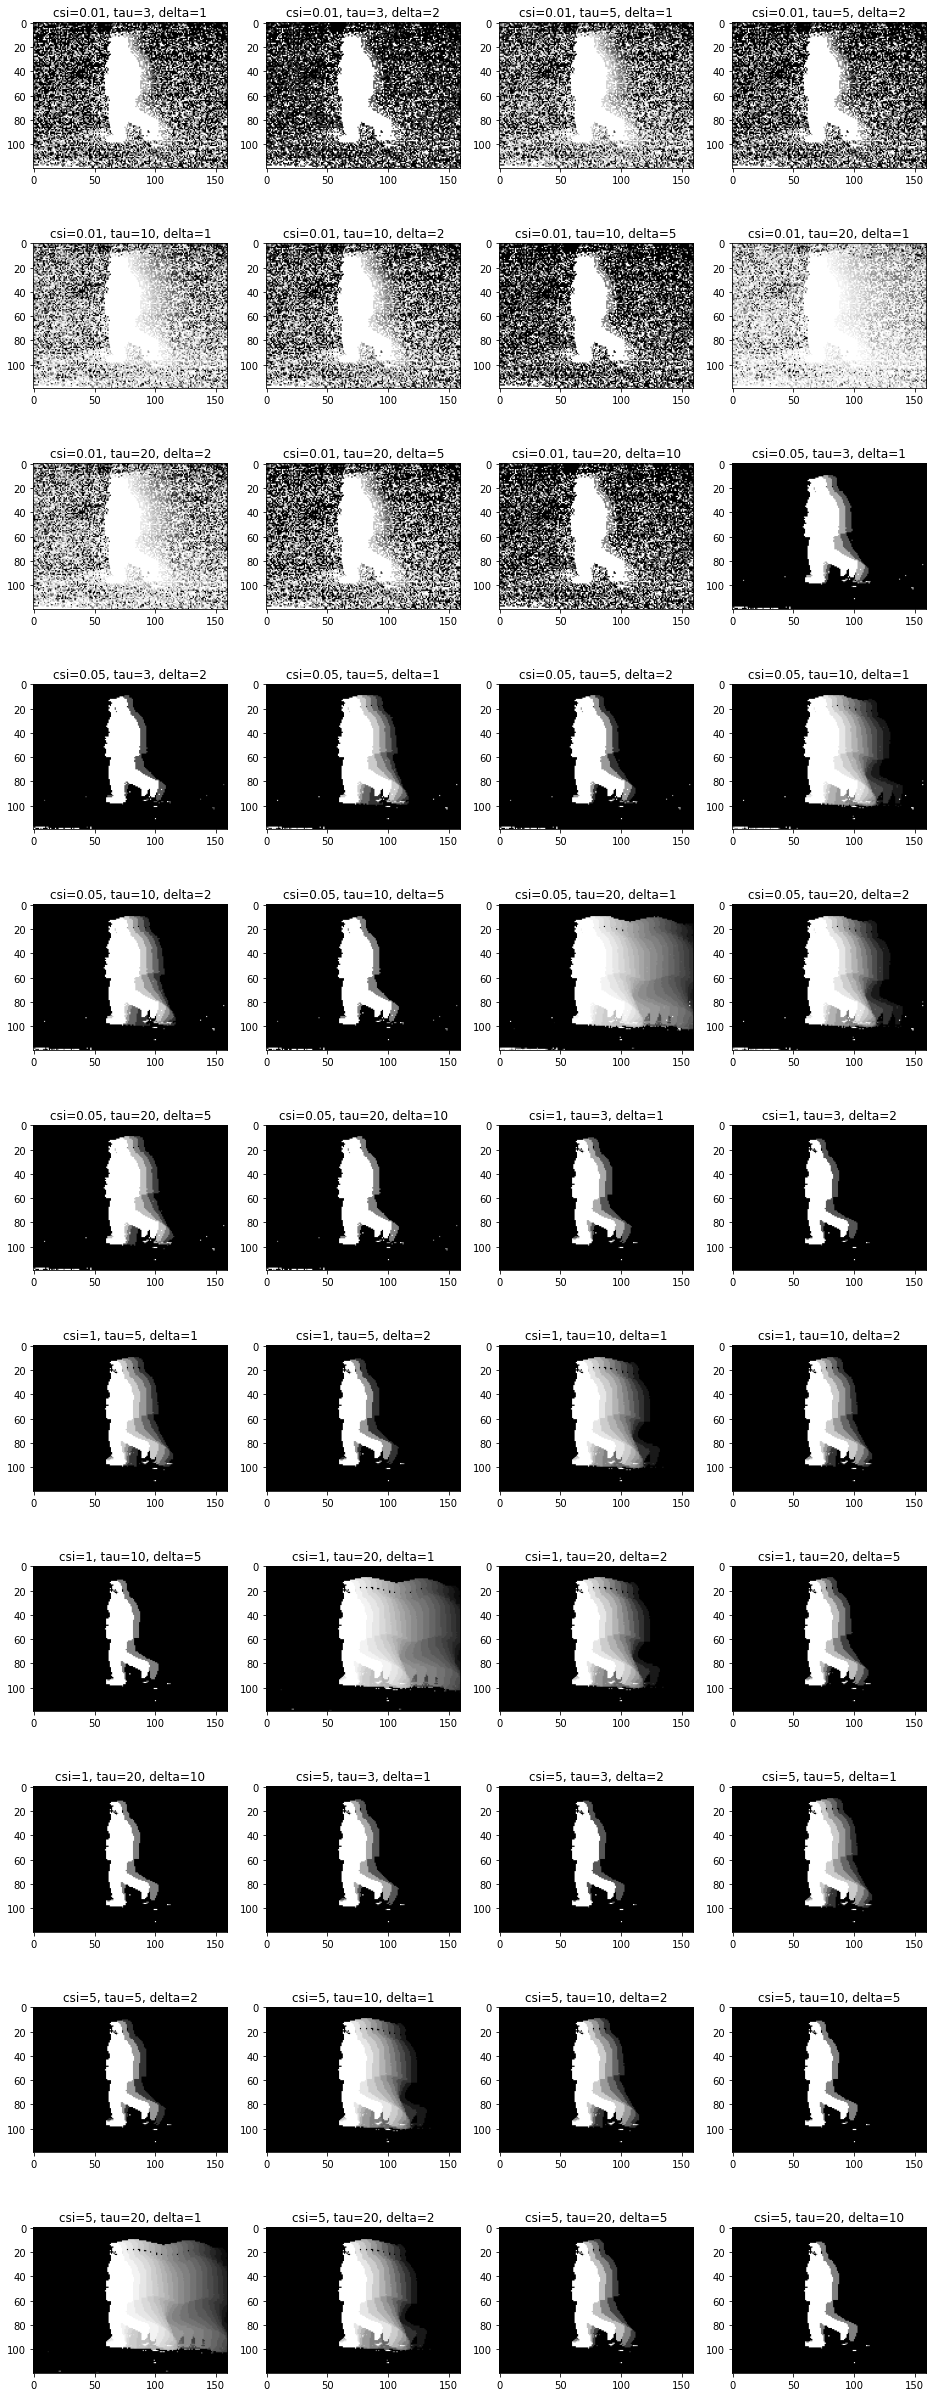

In [ ]:
# example of analysis: this is a possible analysis structure which can be expected,
# i.e. testing different parameter ranges and appreciating what happens, from a visual
# point of view.

taus = [3,5,10,20]
deltas = [1,2,5,10]
csis = [0.01,0.05,1,5]

fig = plt.figure(figsize=(16,48))
j = 1

for csi in csis:

    Psi_list = list()
    Psi_list.append(v_fill[0])
    for t in range(1,T):    
        Psi_tmp = (np.abs(D_list[t]) > csi).astype(int) + v_fill[t]
        Psi = (Psi_tmp != 0).astype(int)
        Psi_list.append(Psi)

    for tau in taus:
        for delta in deltas:

            if delta >= tau:
                pass # delta should be smaller than tau
            else:
                H_list = list()
                H_list.append(v_fill[0])
                for t in range(1,T-1):
                    H = (Psi_list[t]*tau) + (1-Psi_list[t])*np.maximum(0,H_list[t-1]-delta)
                    H_list.append(H)

                plt.subplot(12,4,j)
                plt.imshow(H_list[26], cmap='gray')
                plt.title('csi={}, tau={}, delta={}'.format(csi,tau,delta))
                j += 1

It should be noted that noise in the MHIs can be controlled with the csi parameter (threshold on gray-level differences). The tau and delta parameters, instead, provide a more 'visual' contribution to the MHI. The larger tau, the more past frames are included in the motion tracking, and viceversa. With small deltas, the trace of past motions is very smooth, and viceversa. When delta and tau have too similar values, not much can be seen, as pixel intensities of past motions approach zero too quickly. Also too small a value of delta with respect to tau provides results which can be confusing (the man is hardly recognisable).